# Final Project Title
## Brendan, Nathan, Yash, Rennie

## Introduction
We want to find the most optimal deck in terms of win rate. We will do this by looking at both individual cards and decks. We will analyze cards based on rarity and elixir and decks based on average elixir and deck composition in terms of types of cards.

## Data Collection/Curation
We got this data from Kaggle. Provide link to kaggle site. These datasets include ... . Describe the process of adding relevant information to card_list including type of card, rarity, elixir cost, if its flying, if it spawns units etc.

## Data management/representation

Discuss reading data into pandas.
Discuss creating a dataframe that contains each deck and information about the deck.
Discuss creating a dataframe that contains each card and information about the card.

In [70]:
# Imports
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter
import math
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:
data_games = pd.read_csv("data_ord.csv")
data_card_list = pd.read_csv("cardlist.csv")

### Finding Each Deck
Extracting each deck, occurrences of each deck, and amount of wins of each deck and saves it in a dataframe.
This will allow us to calculate things like win rate.

In [192]:
# Deck Section
# Extracting interesting deck data
dict_decks_general = {} # All decks and how many times they were found
dict_decks_general = defaultdict(lambda:0,dict_decks_general) # zero filled dictionary
dict_decks_winning_only = {} # All decks that won a game, and how many times they won
dict_decks_winning_only = defaultdict(lambda:0,dict_decks_winning_only) # zero filled dictionary

dict_decks_trophies = {}
dict_decks_trophies = defaultdict(lambda:0,dict_decks_trophies) # zero filled dictionary


# function to obtain deck info
# Takes in the player 1 and player 2 decks and the outcome of the match
def get_decks(p1_deck,p2_deck,p1_trophies,p2_trophies,result):
    global dict_decks_general
    global dict_decks_winning_only
    global dict_decks_trophies
    dict_decks_general[p1_deck] = dict_decks_general[p1_deck] + 1 # add 1 to player 1's deck occurrences
    dict_decks_general[p2_deck] = dict_decks_general[p2_deck] + 1 # add 1 to player 2's deck occurrences
    dict_decks_trophies[p1_deck] = dict_decks_trophies[p1_deck] + p1_trophies
    dict_decks_trophies[p2_deck] = dict_decks_trophies[p2_deck] + p2_trophies
    if(result == 1):
        dict_decks_winning_only[p1_deck] = dict_decks_winning_only[p1_deck] + 1 # if player 1 wins add 1 to player 1's deck occurrences for winning decks
    else:
        dict_decks_winning_only[p2_deck] = dict_decks_winning_only[p2_deck] + 1 # if player 2 wins add 1 to player 2's deck occurrences for winning decks

# apply function to data_frame containing games
data_games.apply(lambda x: get_decks((x["p1card1"],x["p1card2"],x["p1card3"],x["p1card4"],x["p1card5"],x["p1card6"],x["p1card7"],x["p1card8"]),(x["p2card1"],x["p2card2"],x["p2card3"],x["p2card4"],x["p2card5"],x["p2card6"],x["p2card7"],x["p2card8"]),x["p1trophies"],x["p2trophies"],x["outcome"]), axis=1)

# create new dataframe containing information found
# has the columns 'Deck', 'Occurrences', and 'Wins'
data_decks = pd.DataFrame.from_dict([dict_decks_general]).transpose().reset_index().rename(columns={"index": "Deck", 0: "Occurrences"})
data_decks['Wins'] = data_decks['Deck'].apply(lambda x: dict_decks_winning_only[x])
data_decks['Trophies'] = dict_decks_trophies.values()
data_decks['Trophies'] = data_decks['Trophies']/data_decks['Occurrences']
data_decks.head()

,Deck,Occurrences,Wins,Trophies
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30,17,6963.566667
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22,9,7339.909091
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183,83,6996.245902
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778,959,6912.115861
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910,1064,6769.385864


### Gathering Important Data About Decks
Obtaining stats that will be useful for analysis of decks. This includes things like the deck composition, rarity, average elixer cost, and Win Rate. Composition is stored as a string of 3 numbers. The character at index 0 corresponds to the number of buildings in the deck, at index 1 the number of spells, and at index 2 the number of units. Rarity is stored as a string of 5 numbers. The character at index 0 corresponds to the number of champions in the deck (which can at most be 1), at index 1 the number of legendaries, and at index 2 the number of epics, at index 3 the number of rares, and at index 4 the number of commons.

In [194]:
# Obtain deck specific info
comps = [] # 1 to 1 list of compostion of each deck
rarities = [] # 1 to 1 list of rarities in each deck
costs = [] # 1 to 1 list of cost of each deck

# function to find the important information for each deck
def findComp(deck):
    global comps
    global rarities
    comp = 0
    rarity = 0
    total = 0
    # for each card in the deck
    for card in deck:
        curr_type = data_card_list.loc[card].type # find type of card
        curr_rarity = data_card_list.loc[card].rarity # find rarity of card
        total += data_card_list.loc[card].cost # find cost of card
        # adjust the compostion accordingly
        if(curr_type == "unit"):
            comp += 1
        elif(curr_type == "spell"):
            comp += 10
        elif(curr_type == "defense" or curr_type == "spawner" or curr_type == "siege" or curr_type == "building"):
            # defense, spawner, siege, and buildings all count as buildings
            comp += 100
            
        # adjust the rarity accordingly
        if(curr_rarity == "common"):
            rarity += 1
        elif(curr_rarity == "rare"):
            rarity += 10
        elif(curr_rarity == "epic"):
            rarity += 100
        elif(curr_rarity == "legendary"):
            rarity += 1000
        elif(curr_rarity == "champion"):
            rarity += 10000
    # pad the composition string and rarity string with zeros to allow for accuracte indexing
    comps.append(str(comp).zfill(3))
    rarities.append(str(rarity).zfill(5))
    # find average elixir cost of deck
    costs.append(total/8)
    
# call function to find information on each deck
data_decks['Deck'].apply(lambda x: findComp(x))
# Create 'Rarity', 'Composition',and 'Costs' columns based on results
data_decks['Rarity'] = rarities
data_decks['Composition'] = comps
data_decks['Costs'] = costs
# Find the win rate of each deck and save it in 'Win Rate' columns
data_decks['Win Rate'] = data_decks.apply(lambda x: x['Wins']/x['Occurrences'], axis=1)
data_decks.head()

,Deck,Occurrences,Wins,Trophies,Rarity,Composition,Costs,Win Rate
0,"(8, 34, 37, 52, 69, 88, 92, 97)",30,17,6963.566667,12212,035,4.25,0.566667
1,"(11, 12, 13, 58, 77, 86, 87, 98)",22,9,7339.909091,01331,224,3.25,0.409091
2,"(11, 37, 53, 83, 88, 92, 97, 102)",183,83,6996.245902,02213,143,3.75,0.453552
3,"(19, 22, 25, 32, 54, 76, 87, 98)",1778,959,6912.115861,02213,125,3.50,0.539370
4,"(28, 38, 43, 46, 50, 81, 102, 103)",1910,1064,6769.385864,02141,116,4.00,0.557068


## Data Analysis

### Card Analysis

### Deck Analysis
#### Finding the most popular decks
The first part of the analysis of decks is finding out which decks were used the most. These are the 5 most common decks.

In [85]:
# Finding the 5 most common decks
display(data_decks.sort_values(by=['Occurrences'], ascending=False).head(5))

,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
13,"(10, 14, 21, 30, 38, 74, 87, 98)",32405,15767,125,01043,2.625,0.486561
27,"(4, 36, 42, 46, 50, 62, 87, 95)",24027,12734,026,04121,3.875,0.529987
176,"(0, 26, 30, 41, 77, 90, 91, 98)",18166,8849,134,02123,3.250,0.487119
14,"(6, 34, 35, 37, 63, 92, 99, 102)",16286,9002,035,02600,4.000,0.552745
43,"(0, 1, 10, 72, 80, 82, 87, 98)",10385,5229,224,01115,3.000,0.503515


The second part of analysis is looking at which decks won the most. Interestingly, we notice that the third most common deck has less wins than the fourth most common deck, despite having almost 20000 more games.

In [83]:
# Finding the 5 most winning decks
display(data_decks.sort_values(by=['Wins'], ascending=False).head(5))

,Deck,Occurrences,Wins,Composition,Rarity,Costs,Win Rate
13,"(10, 14, 21, 30, 38, 74, 87, 98)",32405,15767,125,01043,2.625,0.486561
27,"(4, 36, 42, 46, 50, 62, 87, 95)",24027,12734,026,04121,3.875,0.529987
14,"(6, 34, 35, 37, 63, 92, 99, 102)",16286,9002,035,02600,4.000,0.552745
176,"(0, 26, 30, 41, 77, 90, 91, 98)",18166,8849,134,02123,3.250,0.487119
43,"(0, 1, 10, 72, 80, 82, 87, 98)",10385,5229,224,01115,3.000,0.503515


#### Analyzing Deck Composition
##### Finding the most common compositions
Each deck has 8 cards. The types of cards are unit, spell, and building. There can be at most 8 cards of a type in a deck. It is also possible that there are no cards of a type in a deck. We wish to find the 5 most common compositions of decks in terms of type of cards.

In [217]:
# Finding the 5 most common general compositions
most_common_comps = data_decks['Composition'].value_counts()[0:5]

for index in most_common_comps.index:
    print("Buildings: "+index[0]+", Spells: "+index[1]+", Units: "+index[2]," | Occurences: "+str(most_common_comps[index]))
    # Finding most popular deck of each composition in the top 5
    deck = ""
    for card in data_decks[data_decks['Composition'] == index].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_card_list.loc[card].card + ","
    print("Deck: "+ deck[:-1]+"\n")

Buildings: 0, Spells: 2, Units: 6  | Occurences: 91676
Deck:  P.E.K.K.A, Battle Ram, Electro Wizard, Bandit, Royal Ghost, Magic Archer, Fireball, Zap

Buildings: 1, Spells: 2, Units: 5  | Occurences: 66117
Deck:  Skeletons, Musketeer, Hog Rider, Ice Spirit, Ice Golem, Cannon, Fireball, The Log

Buildings: 0, Spells: 3, Units: 5  | Occurences: 42565
Deck:  Balloon, Bowler, Lumberjack, Inferno Dragon, Electro Dragon, Freeze, Tornado, Barbarian Barrel

Buildings: 0, Spells: 1, Units: 7  | Occurences: 38373
Deck:  Spear Goblins, Miner, Inferno Dragon, Goblin Gang, Bats, Mega Knight, Skeleton Barrel, Zap

Buildings: 1, Spells: 3, Units: 4  | Occurences: 31398
Deck:  Knight, Princess, Ice Spirit, Goblin Gang, Inferno Tower, Rocket, Goblin Barrel, The Log



The most common composition is 0 buildings, 2 spells, and 6 units. We notice that generally the number of buildings < number of spells < number of units. Interestingly, we notice that most of these decks contain unique units but the spells are similar.

##### Finding the least common compositions
We wish to find the 5 least common compositions

In [218]:
# Finding 5 least common compositions
least_common_comps = data_decks['Composition'].value_counts()[-6:]

for index in least_common_comps.index:
    print("Buildings: "+index[0]+", Spells: "+index[1]+", Units: "+index[2]," | Occurences: "+str(least_common_comps[index]))
    # Finding least popular deck of each composition in bottom top 5
    deck = ""
    for card in data_decks[data_decks['Composition'] == index].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_card_list.loc[card].card + ","
    print("Deck: "+ deck[:-1]+"\n")

Buildings: 4, Spells: 0, Units: 4  | Occurences: 6
Deck:  Bowler, Dart Goblin, Flying Machine, Firecracker, Goblin Hut, Elixir Collector, Tombstone, Furnace

Buildings: 6, Spells: 1, Units: 1  | Occurences: 5
Deck:  Fire Spirit, Goblin Hut, Bomb Tower, Barbarian Hut, Tesla, Tombstone, Furnace, Mirror

Buildings: 8, Spells: 0, Units: 0  | Occurences: 5
Deck:  Cannon, Goblin Hut, Mortar, Barbarian Hut, Tesla, X-Bow, Tombstone, Furnace

Buildings: 7, Spells: 0, Units: 1  | Occurences: 4
Deck:  Cannon Cart, Inferno Tower, Bomb Tower, Barbarian Hut, Tesla, X-Bow, Furnace, Goblin Drill

Buildings: 6, Spells: 0, Units: 2  | Occurences: 1
Deck:  Skeleton Army, Mini P.E.K.K.A, Cannon, Mortar, Inferno Tower, Bomb Tower, Tesla, Tombstone

Buildings: 5, Spells: 0, Units: 3  | Occurences: 1
Deck:  Ice Spirit, Fire Spirit, Golden Knight, Goblin Hut, Barbarian Hut, Tombstone, Furnace, Goblin Drill



The least common composition is 5 buildings, 0 spells, and 3 units. We notice that generally the number of buildings > number of spells and number of units. This would indicate that buildings are generally not used very often, especially multiple in the same deck.

##### Visualizing the Compositions
In order to visualize the typical composition of decks, we created a bar chart to indicate how common a certain composition was. The x-axis corresponds to the number of the type of card in the deck while the y-axis corresponds to the number of occurrences of this format.

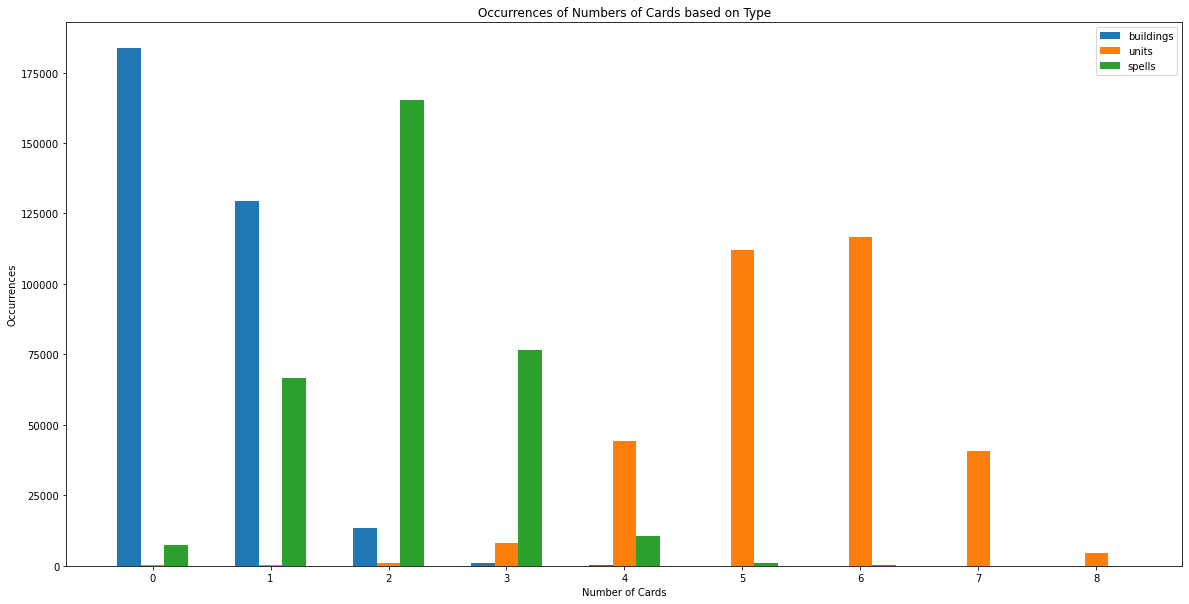

In [182]:
units = data_decks['Composition'].apply(lambda x: int(x[2])).value_counts() # counting the number of units for each deck
spells = data_decks['Composition'].apply(lambda x: int(x[1])).value_counts() # counting the number of spells for each deck
buildings = data_decks['Composition'].apply(lambda x: int(x[0])).value_counts() # counting the number of buildings for each deck

# Creating plot
fig, ax = plt.subplots(figsize=(20,10))
# Setting labels
ax.set_ylabel("Occurrences")
ax.set_xlabel("Number of Cards")
ax.set_title("Occurrences of Numbers of Cards based on Type")
# Plotting occurrences of each composition
ax.bar(buildings.index-.2, buildings.values, .2, label='buildings')
ax.bar(units.index, units.values, .2, label='units')
ax.bar(spells.index + .2, spells.values, .2, label='spells')
ax.set_xticks(np.arange(9), ['0','1','2','3','4','5','6','7','8'])
plt.legend(loc="upper right")
fig.show()

It appears that the most common composition is 0 buildings, 2 spells, and 6 units. This agrees very well with the results from the previous step of finding the 5 most common compositions. The majority of decks tend to run 0 or 1 buildings. This also agrees with our findings that buildings are not typically used in high numbers. The usage data for spells and units is normally distributed, while the usage data of buildings is not. 

#### Analyzing Deck Rarity Composition
##### Finding the most common rarity composition
There are 5 different types of rarities. In increasing rarity, these are common, rare, epic, legendary, and champion. Each deck can have at most one champion in it. 

In [221]:
# Finding the 5 most common rarities
most_common_rars = data_decks['Rarity'].value_counts()[0:5]

for index in most_common_rars.index:
    print("Champions: "+index[0]+", Legendaries: "+index[1]+", Epics: "+index[2]+", Rares: "+index[3]+", Commons: "+index[4]," | Occurences: "+str(most_common_rars[index]))
    # Finding least popular deck of each composition in bottom top 5
    deck = ""
    for card in data_decks[data_decks['Rarity'] == index].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_card_list.loc[card].card + ","
    print("Deck: "+ deck[:-1]+"\n")

Champions: 0, Legendaries: 2, Epics: 2, Rares: 2, Commons: 2  | Occurences: 11973
Deck:  Prince, Princess, Dart Goblin, Goblin Gang, Rascals, Rocket, Goblin Barrel, The Log

Champions: 0, Legendaries: 1, Epics: 3, Rares: 2, Commons: 2  | Occurences: 10339
Deck:  Golem, Bomber, Baby Dragon, Mini P.E.K.K.A, Mega Minion, Night Witch, Arrows, Lightning

Champions: 0, Legendaries: 1, Epics: 2, Rares: 3, Commons: 2  | Occurences: 10236
Deck:  Balloon, Skeletons, Musketeer, Miner, Ice Golem, Bomb Tower, Barbarian Barrel, Giant Snowball

Champions: 0, Legendaries: 1, Epics: 2, Rares: 2, Commons: 3  | Occurences: 10209
Deck:  Balloon, Guards, Lava Hound, Mega Minion, Skeleton Dragons, Tombstone, Fireball, Zap

Champions: 0, Legendaries: 2, Epics: 3, Rares: 1, Commons: 2  | Occurences: 8140
Deck:  Skeleton Army, Prince, Royal Giant, Princess, Dart Goblin, Bats, Mega Knight, Goblin Barrel



The most common rarity composition is 0 champions and 2 legendaries, epics, rares and commons. We notice that generally the number of champions is 0 for all of these and this could be because they are somewhat different to unlock. Also, most deck compositions are pretty diverse in terms of legendaries, epics, rares and commons.

##### Finding the least common rarity compositions
We wish to find the 5 least common rarity compositions

In [222]:
# Finding the 5 most common compositions
least_common_rars = data_decks['Rarity'].value_counts()[-6:]

for index in least_common_rars.index:
    print("Champions: "+index[0]+", Legendaries: "+index[1]+", Epics: "+index[2]+", Rares: "+index[3]+", Commons: "+index[4]," | Occurences: "+str(least_common_rars[index]))
    # Finding least popular deck of each composition in bottom top 5
    deck = ""
    for card in data_decks[data_decks['Rarity'] == index].sort_values(by=['Occurrences'], ascending=False).head(1)['Deck'].values[0]:
        deck = deck + " " + data_card_list.loc[card].card + ","
    print("Deck: "+ deck[:-1]+"\n")

Champions: 1, Legendaries: 6, Epics: 0, Rares: 0, Commons: 1  | Occurences: 7
Deck:  Lumberjack, Inferno Dragon, Electro Wizard, Royal Ghost, Mega Knight, Archer Queen, Mother Witch, Zap

Champions: 1, Legendaries: 0, Epics: 1, Rares: 6, Commons: 0  | Occurences: 4
Deck:  Dart Goblin, Zappies, Flying Machine, Royal Hogs, Golden Knight, Goblin Cage, Fireball, Barbarian Barrel

Champions: 1, Legendaries: 1, Epics: 0, Rares: 6, Commons: 0  | Occurences: 4
Deck:  Valkyrie, Mini P.E.K.K.A, Hog Rider, Electro Wizard, Archer Queen, Goblin Hut, Fireball, Earthquake

Champions: 0, Legendaries: 0, Epics: 0, Rares: 8, Commons: 0  | Occurences: 4
Deck:  Valkyrie, Musketeer, Mini P.E.K.K.A, Hog Rider, Flying Machine, Goblin Hut, Furnace, Fireball

Champions: 1, Legendaries: 0, Epics: 0, Rares: 7, Commons: 0  | Occurences: 1
Deck:  Giant, Valkyrie, Musketeer, Wizard, Mini P.E.K.K.A, Golden Knight, Inferno Tower, Fireball

Champions: 1, Legendaries: 0, Epics: 0, Rares: 0, Commons: 7  | Occurences: 1


The least common rarity composition is 1 champion and 7 commons. We notice that there is a much higher presence of champions here as well as the decks are much less diverse.

##### Visualizing the Rarity Compositions
In order to visualize the typical rarity composition of decks, we created a bar chart to indicate how common a certain rarity composition was. The x-axis corresponds to the number of that rarity in the deck while the y-axis corresponds to the number of occurrences of this format.

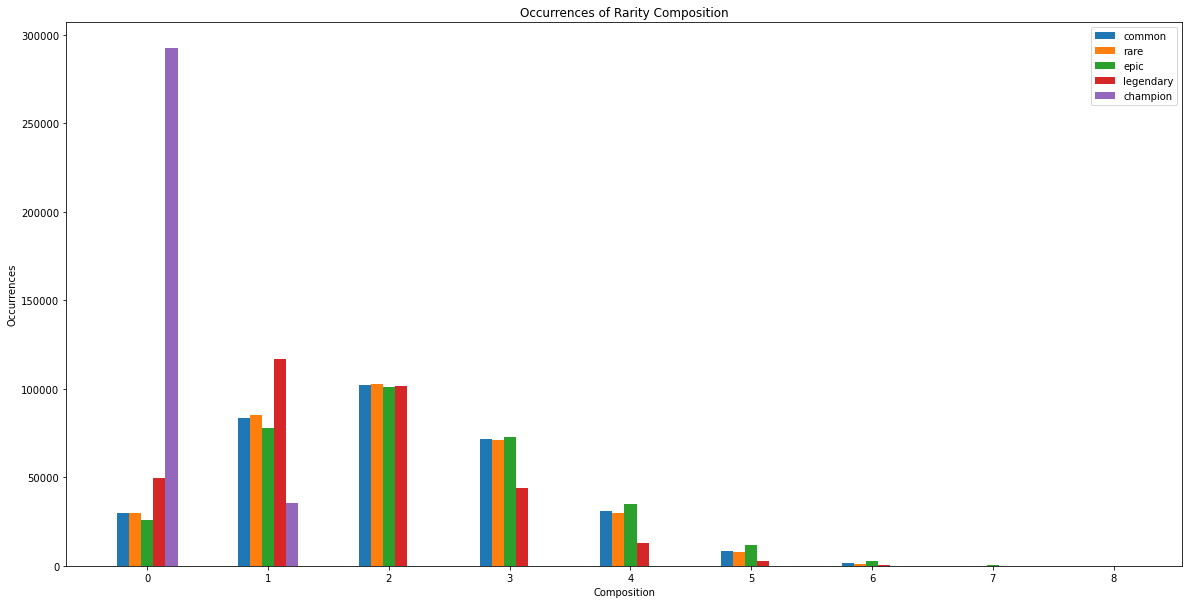

In [223]:
common = data_decks['Rarity'].apply(lambda x: int(x[4])).value_counts() # counting the number of commons
rare = data_decks['Rarity'].apply(lambda x: int(x[3])).value_counts() # counting the number of rares
epic = data_decks['Rarity'].apply(lambda x: int(x[2])).value_counts() # counting the number of epics
legendary = data_decks['Rarity'].apply(lambda x: int(x[1])).value_counts() # counting the number of legendaries
champion = data_decks['Rarity'].apply(lambda x: int(x[0])).value_counts() # counting the number of champions

# Creating plot
fig, ax = plt.subplots(figsize=(20,10))
# Setting labels
ax.set_ylabel("Occurrences")
ax.set_xlabel("Composition")
ax.set_title("Occurrences of Rarity Composition")
# Plotting occurrences of each composition
ax.bar(common.index-.2, common.values, .1, label='common')
ax.bar(rare.index-.1, rare.values, .1, label='rare')
ax.bar(epic.index, epic.values, .1, label='epic')
ax.bar(legendary.index+.1, legendary.values, .1, label='legendary')
ax.bar(champion.index+.2, champion.values, .1, label='champion')

ax.set_xticks(np.arange(9), ['0','1','2','3','4','5','6','7','8'])
plt.legend(loc="upper right")
fig.show()

These results agree with the trend we found in the most and least common rarity compositions. There tends to be a majority of decks that are diverse. This also agrees with our findings that champions are not typically used. The usage data for common, rare, epic, and legendary cards is normally distributed, while the usage data of champions is not. 

## Hypothesis Testing
### Testing For Correlation Between Composition and Win Rate
We will be using two main tests to investigate correlation. We will use the Pearson Correlation Coefficient test whenever our data is normally distributed and the Spearman Correlation Coefficient test whenever our data is not normally distributed.
#### Null Hypothesis 1: There is no correlation between the number of units in a deck and win rate
Our Null Hypothesis states that correlation between the number of units in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of units is normally distributed.

In [224]:
# There is no correlation between number of units and win rate
win_rate = data_decks['Win Rate']
units = data_decks['Composition'].apply(lambda x: int(x[2]))

corr, p = pearsonr(win_rate, units)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation P Value: %e' % p)

Pearsons correlation: -0.006
Pearsons correlation pval: 7.056334e-04


This indicates that there is a weak negative correlation between the number of units in a deck and win rate. There is high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 2: There is no correlation between the number of spells in a deck and win rate
Our Null Hypothesis states that correlation between the number of spells in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of spells is normally distributed.

In [226]:
# There is no correlation between number of spells and win rate
spells = data_decks['Composition'].apply(lambda x: int(x[1]))

corr, p = pearsonr(win_rate, spells)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: 0.008
Pearsons correlation pval: 2.226059e-06


This indicates that there is a weak positive correlation between the number of spells in a deck and win rate. It is somewhat more significant than the correlation between units and win rate. There is high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 3: There is no correlation between the number of buildings in a deck and win rate
Our Null Hypothesis states that correlation between the number of buildings in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Spearman Correlation Coefficient test since the usage of buildings is not normally distributed.

In [230]:
# There is no correlation between number of buildings and win rate
buildings = data_decks['Composition'].apply(lambda x: int(x[0]))

corr, p = spearmanr(win_rate, buildings)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

Spearman correlation: -0.002
Spearman correlation pval: 3.181563e-01


There is a weak correlation between buildings and win rate, but very high uncertainty about the result since P Value > .1. This means that we accept the Null Hypothesis that there is no correlation between buildings and win rate. One reason this P Value might have been so high is due to the lower usage of buildings in general.

### Testing For Correlation Between Rarity Composition and Win Rate
We will again be using the Pearson Correlation Coefficient test whenever our data is normally distributed and the Spearman Correlation Coefficient test whenever our data is not normally distributed.
#### Null Hypothesis 1: There is no correlation between the number of commons in a deck and win rate
Our Null Hypothesis states that correlation between the number of commons in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of commons is normally distributed.

In [231]:
# There is no correlation between number of commons and win rate
common = data_decks['Rarity'].apply(lambda x: int(x[4]))

corr, p = pearsonr(win_rate, common)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: -0.020
Pearsons correlation pval: 4.986060e-29


This indicates that there is a weak negative correlation between the number of commons in a deck and win rate. It is much more significant than the correlations found when analyzing composition. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 2: There is no correlation between the number of rares in a deck and win rate
Our Null Hypothesis states that correlation between the number of rares in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of rares is normally distributed.

In [232]:
rare = data_decks['Rarity'].apply(lambda x: int(x[3]))

corr, p = pearsonr(win_rate, rare)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: -0.024
Pearsons correlation pval: 3.793463e-42


This indicates that there is a weak negative correlation between the number of rares in a deck and win rate. It is more significant than the correlations between commons and win rate. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 3: There is no correlation between the number of epics in a deck and win rate
Our Null Hypothesis states that correlation between the number of epics in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of epics is normally distributed.

In [233]:
epic = data_decks['Rarity'].apply(lambda x: int(x[2]))

corr, p = pearsonr(win_rate, epic)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: 0.018
Pearsons correlation pval: 1.555940e-25


This indicates that there is a weak positive correlation between the number of epics in a deck and win rate. It is the first positive correlation found in rarity composition which may indicate higher rarities lead to better win rates. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 4: There is no correlation between the number of legendaries in a deck and win rate
Our Null Hypothesis states that correlation between the number of legendaries in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Pearson Correlation Coefficient test since the usage of legendaries is normally distributed.

In [235]:
legendary = data_decks['Rarity'].apply(lambda x: int(x[1]))

corr, p = pearsonr(win_rate, legendary)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)

Pearsons correlation: 0.023
Pearsons correlation pval: 1.151631e-38


This indicates that there is a weak positive correlation between the number of legendaries in a deck and win rate. It is also a positive correlation reaffirming the notion that higher rarity might lead to better win rate. It also is slightly stronger than the correlation between epics and win rate. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.

#### Null Hypothesis 5: There is no correlation between the number of champions in a deck and win rate
Our Null Hypothesis states that correlation between the number of champions in a deck and win rate is 0.
To attempt to accept or reject this, we will use a Spearman Correlation Coefficient test since the usage of champions is not normally distributed.

In [236]:
champion = data_decks['Rarity'].apply(lambda x: int(x[0]))

corr, p = spearmanr(win_rate, champion)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

Spearman correlation: 0.016
Spearman correlation pval: 1.146415e-20


There is a weak positive correlation between champions and win rate. This is also a positive correlation which cements the notion that higher rarities lead to higher win rate. There is extremely high certainty that the Null Hypothesis has been rejected since P Value < .01.
#### Analysis of results
We rejected all but one null hypothesis.
Epics, legendaries, and champions all had higher correlations between win rate than commons and rares did. That said, this means that using them in high concentrations is more favorable than using commons and rares in high concentrations. Also, all of the correlations were generally pretty weak. In general, the best decks we saw were all rather diverse.

# Yash Stuff

In [160]:
win_rate = data_decks['Win Rate']
units = data_decks['Costs']

corr, p = pearsonr(win_rate, units)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %e' % p)
corr, p = spearmanr(win_rate, units)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %e' % p)

Pearsons correlation: 0.011
Pearsons correlation pval: 1.022831e-09
Spearman correlation: 0.011
Spearman correlation pval: 1.040226e-09


In [167]:
print(data_decks['Costs'].mean())
print(data_decks[data_decks['Win Rate'] > .50]['Costs'].mean())
print(data_decks[data_decks['Win Rate'] < .50]['Costs'].mean())

3.841473426560621
3.8472610358149404
3.8366994759949016
